In [1]:
import pandas as pd
import re
from collections import Counter
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

In [2]:
# Read the list of filenames from the configuration file
with open('../file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = f"../data/{file}"
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])
data['date'] = pd.to_datetime(data['date'])

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

data["user"] = data["user"].replace("Banties1g", "banties_x")
data["user"] = data["user"].replace("banties1g", "banties_x")
data["user"] = data["user"].replace("fyodor_m_d1821", "fyredoor4")
data["user"] = data["user"].replace("chili_poe", "chili_con_bacon")
data["user"] = data["user"].replace("Wirelesss_", "W1r3lesss")
data["user"] = data["user"].replace("treklul", "trek44_")
data["user"] = data["user"].replace("ttrek_", "trek44_")
data["user"] = data["user"].replace("TriplesingleJ", "TripleSingleJames")


In [3]:
# Find the first stream where each user sent a message
first_stream_df = data.groupby("user")["stream"].min().reset_index()
first_stream_df.rename(columns={"stream": "first_stream"}, inplace=True)

In [4]:
# Merge with the original DataFrame
data = data.merge(first_stream_df, on="user", how="left")
data.tail(10)

,date,user,message,stream,first_stream
1566638,2025-04-13 17:26:20 UTC,BLAS1905,LOL,291,269
1566639,2025-04-13 17:26:20 UTC,banties_x,YESS,291,0
1566640,2025-04-13 17:26:20 UTC,banties_x,YESS,291,0
1566641,2025-04-13 17:26:20 UTC,banties_x,YESS,291,0
1566642,2025-04-13 17:26:21 UTC,andrea4V,no way,291,1
1566643,2025-04-13 17:26:22 UTC,neshpinat,bye,291,262
1566644,2025-04-13 17:26:22 UTC,stan_iv4,LOL,291,135
1566645,2025-04-13 17:26:22 UTC,banties_x,FIANLLY,291,0
1566646,2025-04-13 17:26:23 UTC,inrro,LOL 󠀀,291,270
1566647,2025-04-13 17:26:23 UTC,iNeskoooo,what happend?,291,228


In [5]:
# Count occurrences of first_stream for each stream
pivot_table = data.groupby(["stream", "first_stream"]).size().unstack(fill_value=0)

# Reset index for better readability
pivot_table = pivot_table.reset_index()

In [6]:
pivot_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Columns: 293 entries, stream to 291
dtypes: int64(293)
memory usage: 668.5 KB


In [7]:
pivot_table = pivot_table.drop(columns=['stream'])

In [8]:
pivot_table

first_stream,0,1,2,3,4,5,6,7,8,9,...,282,283,284,285,286,287,288,289,290,291
0,1985,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2105,941,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2150,204,400,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1788,87,103,397,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1842,87,102,80,344,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,549,60,97,2,23,8,16,6,0,10,...,21,10,41,24,88,501,0,0,0,0
288,771,58,72,2,17,55,0,12,5,103,...,39,17,30,70,27,102,596,0,0,0
289,487,16,10,2,11,61,0,37,0,49,...,26,11,10,17,15,33,57,303,0,0
290,585,32,8,2,3,48,1,41,0,44,...,31,27,14,15,32,52,69,46,553,0


In [9]:
# Convert 'date' to datetime format and extract the month for color mapping
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month

# Get the month for each stream
stream_months = data.groupby('stream')['month'].first()

# Get the month for each stream
stream_months = data.groupby("stream")["month"].first()

# Define base colors for each month
base_color_map = {
    1: '#008B8B',  # Dark Cyan
    2: '#FF8C00',  # Dark Orange
    3: '#006400',  # Dark Green
    4: '#8B0000',  # Dark Red
    5: '#450145',  # Dark Purple
    6: '#00008B',  # Dark Blue
    7: '#808000',  # Olive
    8: '#006400',  # Dark Green
    9: '#8B4513',  # SaddleBrown
    10: '#a10202',  # Deep Red
    11: '#242323',  # Dark Gray
    12: '#730049'  # Dark Magenta
}

# Function to generate shades for each month color
def generate_shades(base_color, n_shades, lightness_factor=0.7):
    color = mcolors.to_rgba(base_color)
    light_color = [1 - (1 - c) * (1 - lightness_factor) for c in color]  # Generate a lighter color
    cmap = mcolors.LinearSegmentedColormap.from_list(
        f'shades_of_{base_color}', [color, light_color], N=n_shades)
    return [cmap(i) for i in range(n_shades)]

# Create a color mapping for each stream based on the month
color_list = []
for month in stream_months.unique():
    month_streams = stream_months[stream_months == month].index
    n_streams_in_month = len(month_streams)
    base_color = base_color_map.get(month, "#808080")  # Default gray if month is missing

    # Generate shades
    shades = generate_shades(base_color, n_streams_in_month) if n_streams_in_month > 1 else [base_color]

    # Assign shades to streams
    for i, stream in enumerate(month_streams):
        color_list.append((stream, shades[i]))

# Convert to dictionary for easy lookup
color_dict = dict(color_list)

# Ensure colors match pivot table index
sorted_color_list = [color_dict[stream] for stream in pivot_table.index]

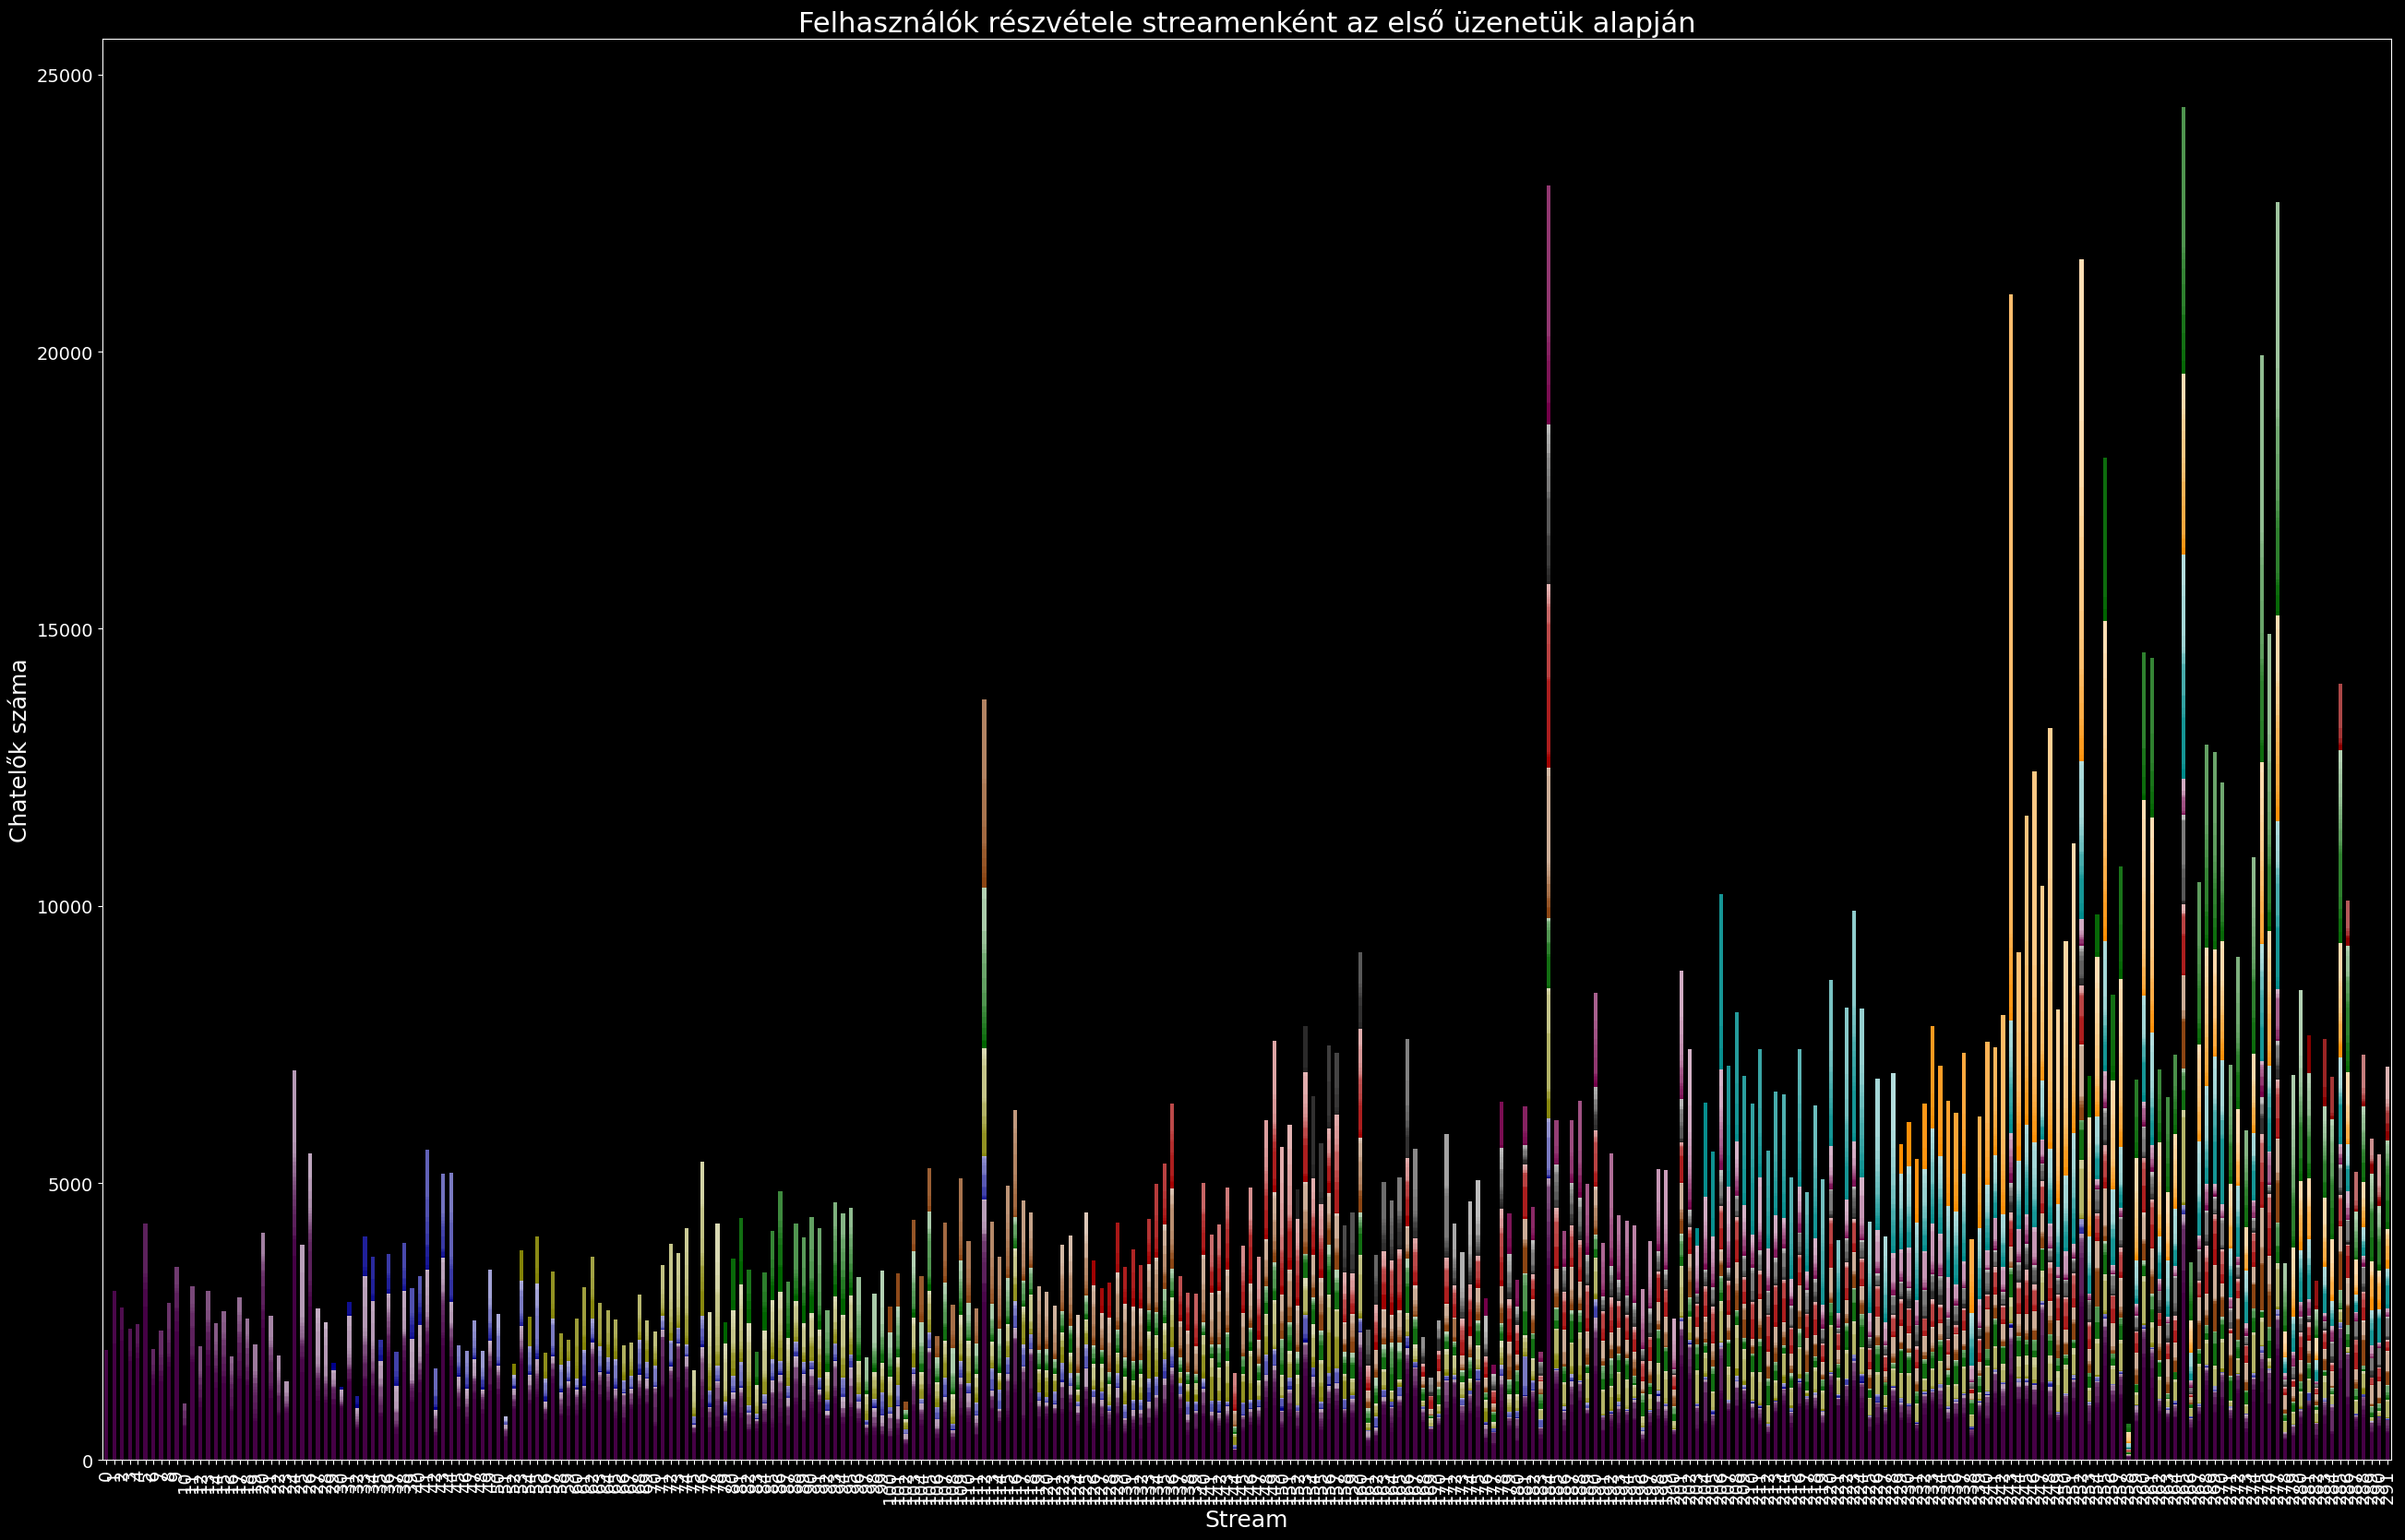

In [10]:
# Plot stacked bar chart
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(32, 20))

pivot_table.plot(kind='bar', stacked=True, ax=ax, color=sorted_color_list, legend=False)

plt.title('Felhasználók részvétele streamenként az első üzenetük alapján', fontsize=22)
plt.xlabel('Stream', fontsize=18)
plt.ylabel('Chatelők száma', fontsize=18)

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [11]:
# Convert pivot table values to percentages (row-wise normalization)
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100


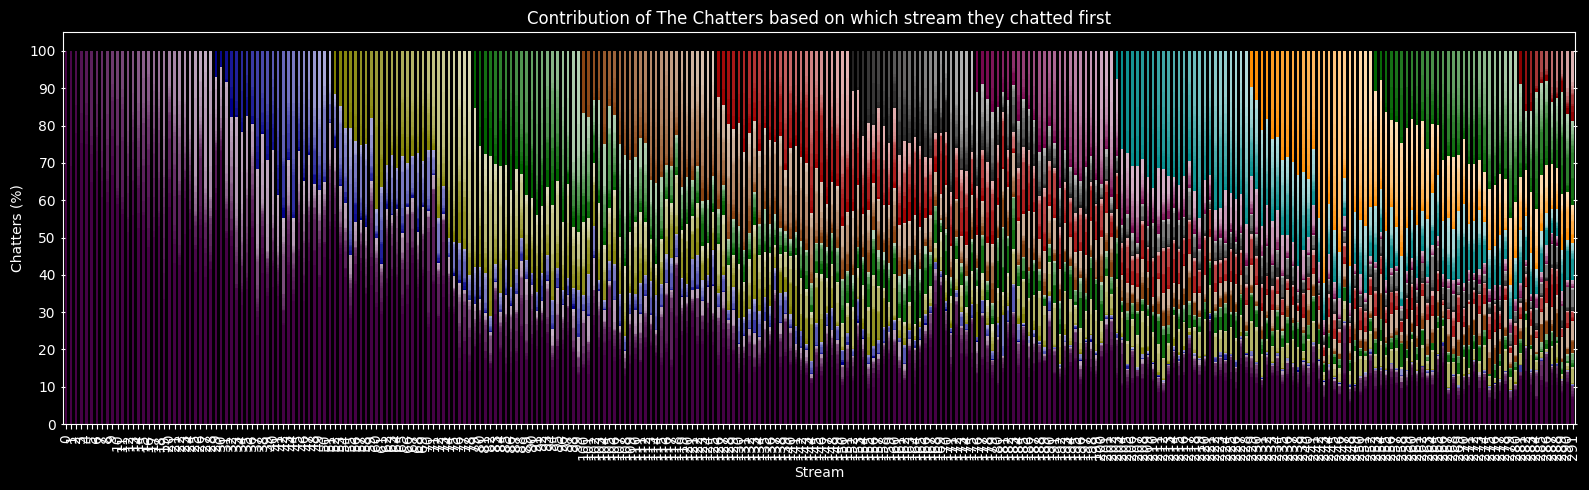

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the percentage data
plt.style.use('dark_background')
ax = pivot_table_percentage.plot(kind='bar', stacked=True, figsize=(16, 5), color=sorted_color_list, legend=False)

plt.title('Contribution of The Chatters based on which stream they chatted first')

# Adjust x and y labels
plt.xlabel('Stream', fontsize=10)  # Make x-axis label smaller
plt.ylabel('Chatters (%)')

# Adjust y-axis ticks to show every 10
plt.yticks(np.arange(0, 101, 10))  

# Show y-axis ticks on both left and right
ax.yaxis.set_ticks_position('both')  
ax.tick_params(axis='y', direction='inout')

plt.tight_layout()
plt.show()

In [13]:
pivot_table_percentage

first_stream,0,1,2,3,4,5,6,7,8,9,...,282,283,284,285,286,287,288,289,290,291
0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,69.107026,30.892974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,78.068264,7.407407,14.524328,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,75.284211,3.663158,4.336842,16.715789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,75.030550,3.543788,4.154786,3.258656,14.012220,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,10.571924,1.155402,1.867899,0.038513,0.442904,0.154054,0.308107,0.115540,0.000000,0.192567,...,0.404391,0.192567,0.789524,0.462161,1.694589,9.647603,0.000000,0.000000,0.000000,0.000000
288,10.545753,0.793325,0.984817,0.027356,0.232526,0.752291,0.000000,0.164136,0.068390,1.408836,...,0.533443,0.232526,0.410341,0.957461,0.369307,1.395158,8.152100,0.000000,0.000000,0.000000
289,8.395104,0.275815,0.172384,0.034477,0.189622,1.051543,0.000000,0.637821,0.000000,0.844682,...,0.448199,0.189622,0.172384,0.293053,0.258576,0.568867,0.982589,5.223237,0.000000,0.000000
290,10.617060,0.580762,0.145191,0.036298,0.054446,0.871143,0.018149,0.744102,0.000000,0.798548,...,0.562613,0.490018,0.254083,0.272232,0.580762,0.943739,1.252269,0.834846,10.036298,0.000000


In [14]:
#pivot_table.to_excel('your_excel_file.xlsx', sheet_name='Pivot Table')